<a href="https://colab.research.google.com/github/eeuuais/studypolio/blob/main/(pytorch)mnist_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [6]:
is_cuda = torch.cuda.is_available()   # GPU가 사용가능한지
device = torch.device("cuda" if is_cuda else "cpu") # GPU가 사용가능하다면 GPU를 사용 아니면 CPU 사용
print(is_cuda, device)

True cuda


In [11]:
# 딥러닝의 재현성을 위해 랜덤 시드를 고정시켜준다.
# 내가 했던 실험을 다른 사람이 시도했을 때 똑같이 나와야한다.랜덤 시드를 고정시키기

random.seed(1010)        # python seed
torch.manual_seed(1010)  # torch seed

if device == 'cuda':
  torch.cuda.manual_seed_all(1010) #gpu seed

In [12]:
#하이퍼 파라미터 선언

# training
EPOCH = 10
BATCH_SIZE = 128
LR = 0.01

# Model
HIDDEN_1 = 32
HIDDEN_2 = 32

TORCH 비전이라는 패키지!! 설치해준다 컴퓨터 비전에서 널리 사용되는 패키지

In [14]:
# MNIST dataset

mnist_train = datasets.MNIST(root='MNIST/', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='MNIST/', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Image Size: torch.Size([28, 28])
Label: 5


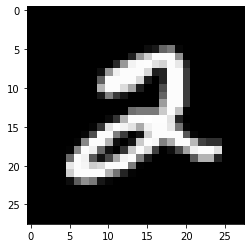

In [19]:
# plt.imshow()
plt.imshow(mnist_train.data[5], cmap='gray')
print(f'Image Size: {mnist_train.data[0].shape}')
print(f'Label: {mnist_train.targets[0]}')

In [20]:
# 데이터 로더 선언

train_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE)

In [22]:
# model 선언(RE)

model = nn.Sequential(
    nn.Linear(1*28*28, HIDDEN_1),
    nn.ReLU(),
    nn.Linear(HIDDEN_1, HIDDEN_2),
    nn.ReLU(),
    nn.Linear(HIDDEN_2, 10),
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=10, bias=True)
)


In [25]:
# loss Optimizer 정의(RE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [26]:
# train / test

def train(epoch):
  model.train()

  running_loss = 0
  for i, (data, targets) in enumerate(train_loader):
    data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data.view(-1, 1*28*28))

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"[{epoch}/{EPOCH}] train loss: {running_loss/len(train_loader):.4f}")
  return running_loss/len(train_loader)

In [27]:
def test():
  model.eval() 
  correct = 0

  with torch.no_grad():
    for data, targets in test_loader:
      data.to(device), targets.to(device)

      outputs = model(data.view(-1, 1*28*28))

      _, predicted = torch.max(outputs, 1)  
      correct += predicted.eq(targets.view_as(predicted)).sum()

  data_num = len(test_loader.dataset)  # 데이터 총 갯수
  print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

In [28]:
test()

Test Accuracy: 810/10000 (8.10%)


In [29]:
for epoch in range(EPOCH):
  train(epoch)
test()

[0/10] train loss: 0.3093
[1/10] train loss: 0.1635
[2/10] train loss: 0.1319
[3/10] train loss: 0.1199
[4/10] train loss: 0.1100
[5/10] train loss: 0.1016
[6/10] train loss: 0.0955
[7/10] train loss: 0.0883
[8/10] train loss: 0.0917
[9/10] train loss: 0.0831
Test Accuracy: 9613/10000 (96.13%)


In [30]:
# MNIST dataset
from torch.utils.data.sampler import SubsetRandomSampler

indices = list(range(len(mnist_train)))
split = 50000
train_indices, val_indices = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE)

In [31]:
def validation(epoch):
  model.eval() 

  correct = 0
  running_loss = 0.

  with torch.no_grad():
    for i, (data, targets) in enumerate(val_loader):
      data.to(device), targets.to(device)
      
      outputs = model(data.view(-1, 1*28*28))
      loss = criterion(outputs, targets)
      running_loss += loss.item()

      _, predicted = torch.max(outputs, 1)  
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # 정확도 출력
  data_num = len(val_indices)  # 데이터 총 건수
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] val loss: {running_loss/len(val_loader):.4f} val acc: {correct}/{data_num} ({acc:.0f}%)')
  
  return running_loss/len(val_loader)

In [32]:
train_losses = []
val_losses = []
for epoch in range(EPOCH):
  tloss = train(epoch)
  vloss = validation(epoch)
  train_losses.append(tloss)
  val_losses.append(vloss)
test()

[0/10] train loss: 0.0769
[0/10] val loss: 0.0735 val acc: 9760/10000 (98%)
[1/10] train loss: 0.0819
[1/10] val loss: 0.0860 val acc: 9731/10000 (97%)
[2/10] train loss: 0.0696
[2/10] val loss: 0.0918 val acc: 9751/10000 (98%)
[3/10] train loss: 0.0724
[3/10] val loss: 0.0900 val acc: 9746/10000 (97%)
[4/10] train loss: 0.0702
[4/10] val loss: 0.0971 val acc: 9726/10000 (97%)
[5/10] train loss: 0.0646
[5/10] val loss: 0.1005 val acc: 9734/10000 (97%)
[6/10] train loss: 0.0636
[6/10] val loss: 0.1172 val acc: 9699/10000 (97%)
[7/10] train loss: 0.0650
[7/10] val loss: 0.1419 val acc: 9631/10000 (96%)
[8/10] train loss: 0.0626
[8/10] val loss: 0.1454 val acc: 9649/10000 (96%)
[9/10] train loss: 0.0624
[9/10] val loss: 0.1189 val acc: 9715/10000 (97%)
Test Accuracy: 9675/10000 (96.75%)


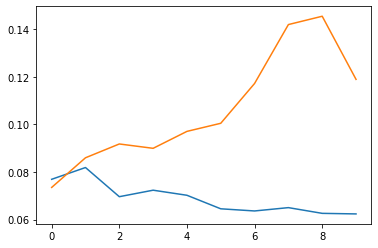

In [33]:
plt.plot(train_losses)
plt.plot(val_losses)

Prediction: 1 / Label: 1


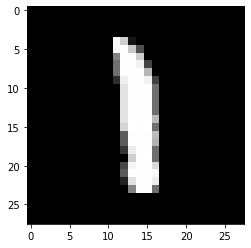

In [34]:
model.eval()

idx = 777
data = mnist_test.data[idx]
label = mnist_test.targets[idx]

output = model(data.view(28*28).float())
pred = torch.argmax(output)

print(f"Prediction: {pred} / Label: {label}")
plt.imshow(data, cmap='gray')